In [ ]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install --upgrade pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
   

In [ ]:
from datasets import Dataset
import re
from transformers import GPT2Tokenizer
from transformers import GPT2Config, GPT2LMHeadModel
import torch
from transformers import DataCollatorForLanguageModeling
from huggingface_hub import notebook_login
from transformers import Trainer, TrainingArguments
import subprocess


## preprocessing

In [ ]:

def preprocess_text(data):
    # Step 1: Remove text within parentheses
    data = re.sub(r'\([^)]*\)', '', data)

    # Step 2: Remove all-uppercase words (likely sound effects)
    data = re.sub(r'\b[A-Z]+\b', '', data)

    # Step 3: Convert to lowercase
    data = data.lower()

    # Step 4: Normalize spaces
    data = re.sub(r'\s+', ' ', data).strip()

    return data

# Load the data
file_path = '/content/drive/MyDrive/data/text_data.zip (Unzipped Files)/train_100M/open_subtitles.train'


with open(file_path, 'r') as file:
    raw_data = file.read()

# Apply preprocessing
cleaned_data = preprocess_text(raw_data)

# Display a sample of the cleaned data
print(raw_data[:500])


- Dad.
- We're going right now, Martin, very far away
(MARTIN PANTING)
George, why are you waiting? 
Let's go.
He's still in here.
Peter, he's still here.
Get the boy out of this house.
Out of this house!
Dad, I'm cold.
George, I beg of you, let's go!
I'm not finished, Peter.
It's not over yet.
Where's Mom and Carole?
They're in a safe place.
Martin?
(SCREAMING)
(CACKLING)
(CACKLING)
Peter.
(DRAMATIC MUSIC PLAYING)
(MUFFLED GHOSTLY VOICES)
(DOOR CREAKS SHUT)
Martin.
(ELECTRICITY BUZZING)
BETTE: 


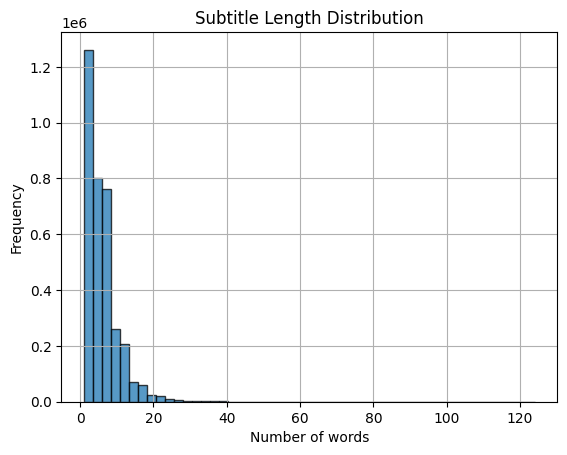

Mean Length: 5.718180401619402
Median Length: 5.0
Max Length: 124
Min Length: 1


In [ ]:
# Plot Subtitle Length Distribution
import matplotlib.pyplot as plt
import numpy as np


subtitles = raw_data.split('\n')
subtitle_lengths = [len(subtitle.split()) for subtitle in subtitles if subtitle.strip()]  # Token count per subtitle


plt.hist(subtitle_lengths, bins=50, alpha=0.75, edgecolor='black')
plt.title('Subtitle Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate and display statistics for subtitle lengths
mean_length = np.mean(subtitle_lengths)
median_length = np.median(subtitle_lengths)
max_length = np.max(subtitle_lengths)
min_length = np.min(subtitle_lengths)

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")

POS Tag Distribution: Counter({'PUNCT': 4583, 'PRON': 3276, 'VERB': 3129, 'NOUN': 3048, 'AUX': 1912, 'ADP': 1559, 'DET': 1433, 'ADV': 999, 'PROPN': 984, 'ADJ': 969, 'PART': 863, 'CCONJ': 365, 'SCONJ': 339, 'INTJ': 306, 'NUM': 267, 'X': 86, 'SYM': 16})


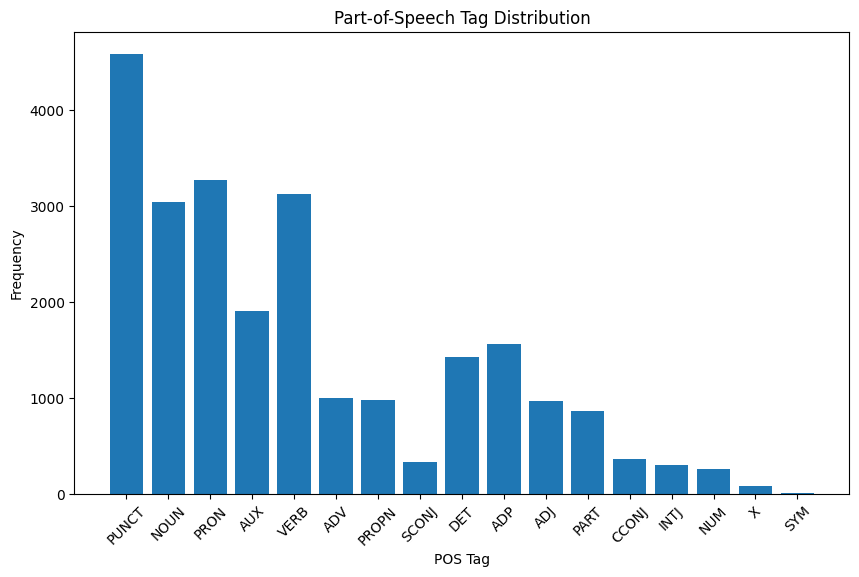

Tense Distribution: Counter({'Pres': 944, 'Past': 801})


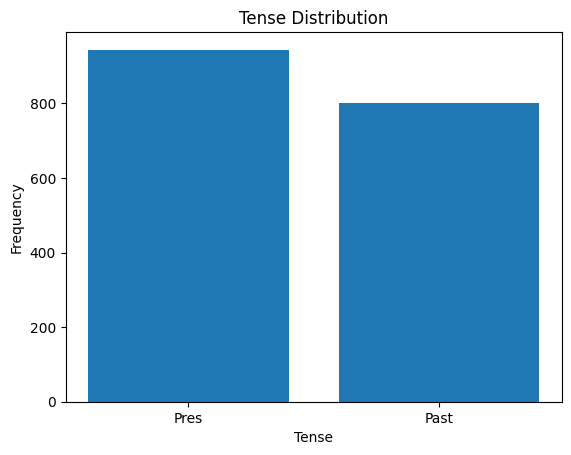

Colloquial Expressions Found: Counter({'wanna': 3})


In [ ]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Analyze a sample of cleaned data
sample_data = cleaned_data[:100000]
doc = nlp(sample_data)

# Sentence Structure Analysis
pos_tags = [token.pos_ for token in doc]
pos_counts = Counter(pos_tags)
print("POS Tag Distribution:", pos_counts)

# Plot POS Tag Distribution
plt.figure(figsize=(10, 6))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title("Part-of-Speech Tag Distribution")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Tense Analysis
verb_tenses = []
for token in doc:
    if token.pos_ == "VERB":
        tense = token.morph.get("Tense")
        if tense:
            verb_tenses.extend(tense)

tense_counts = Counter(verb_tenses)
print("Tense Distribution:", tense_counts)

# Plot Tense Distribution
plt.bar(tense_counts.keys(), tense_counts.values())
plt.title("Tense Distribution")
plt.xlabel("Tense")
plt.ylabel("Frequency")
plt.show()

# Colloquial Expression Analysis
colloquialisms = [token.text for token in doc if token.text.lower() in {"gonna", "wanna", "y'all", "ain't"}]
print("Colloquial Expressions Found:", Counter(colloquialisms))


## tokenization

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("babylm/babyllama-100m-2024")

# Load the model configuration without pretrained weights
config = AutoConfig.from_pretrained("babylm/babyllama-100m-2024")
model = AutoModelForCausalLM.from_config(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
config._attn_implementation

'eager'

In [ ]:
config

LlamaConfig {
  "_name_or_path": "babylm/babyllama-100m-2024",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "max_position_embeddings": 256,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 8,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.46.2",
  "use_cache": true,
  "vocab_size": 16000
}

In [ ]:
# Print the model size
model_size = sum(t.numel() for t in model.parameters())
print(f"babyllama size: {model_size/1000**2:.1f}M parameters")
# Check the maximum sequence length
print(f"Maximum input size for the model: {config.max_position_embeddings}")
print(model)

babyllama size: 58.3M parameters
Maximum input size for the model: 256
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=512, out_features=1024, bias=False)
          (up_proj): Linear(in_features=512, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((512,), eps=1e-06)
        (post_attent

In [ ]:
# Tokenize the data

max_length = 256
input_texts = [cleaned_data[i:i+max_length] for i in range(0, len(cleaned_data), max_length)]

# Apply the tokenizer to each chunk
tokenized_data = tokenizer(input_texts, padding=True, truncation=True, return_tensors="pt")

# Display a sample of tokenized data
print(tokenized_data["input_ids"][:5])

tensor([[   15,  2280,    16,   338,   261,   411,   537,   466,   471,    14,
          9794,   193,    14,   557,  1039,   751,  3950, 15690,    14,   744,
           329,   220,  2481,    33,   585,   243,   314,    16,   239,   243,
           854,   237,   427,    16,   225,  1321,    14,   239,   243,   854,
           427,    16,   401,   196,   875,   390,   235,   321,   824,    16,
           390,   235,   321,   824,     3,  2280,    14,   539,    79,  1852,
            16,  3950, 15690,    14,  1003,   235,   220,    14,   585,   243,
           314,     3,   539,    79,   320,  2039,    14,   225,  1321,    16,
          1708,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
from datasets import Dataset

dataset = Dataset.from_dict(tokenized_data)

# Splitting the dataset into train and test sets
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

## Training

In [ ]:
notebook_login()

In [ ]:
training_args = TrainingArguments(
    output_dir='Harshatheeswar',
    hub_model_id='babylama-scratch',
    evaluation_strategy='epoch',
    auto_find_batch_size=True,
    num_train_epochs=5,
    gradient_accumulation_steps=8,
    weight_decay=0.1,
    lr_scheduler_type='cosine',
    learning_rate=5e-5,
    fp16=True,
    push_to_hub=True,
    logging_steps=10
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Push the trained model to the Hugging Face Hub
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
0,4.303800,4.316248
1,4.049500,4.065654
2,3.889400,3.957891
4,3.730000,3.914025


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


events.out.tfevents.1730821957.c6e2ac2101d4.6774.0:   0%|          | 0.00/598k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Harshatheeswar/babylama-scratch/commit/cad59ecb2e467b27c10b9e03c8131995f218fc53', commit_message='End of training', commit_description='', oid='cad59ecb2e467b27c10b9e03c8131995f218fc53', pr_url=None, pr_revision=None, pr_num=None)

## evaluation

In [ ]:

%cd /content/drive/MyDrive/

!git clone https://github.com/babylm/evaluation-pipeline-2024 new_evaluation_pipeline


/content/drive/MyDrive
Cloning into 'new_evaluation_pipeline'...
remote: Enumerating objects: 26187, done.
remote: Total 26187 (delta 0), reused 0 (delta 0), pack-reused 26187 (from 1)
Receiving objects: 100% (26187/26187), 51.28 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (17625/17625), done.
Updating files: 100% (3329/3329), done.


In [ ]:
%cd /content/drive/MyDrive/new_evaluation_pipeline


/content/drive/MyDrive/new_evaluation_pipeline


In [ ]:
!pip install -e
!pip install minicons
!pip install --upgrade accelerate


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!python ewok/dl_and_filter.py


Traceback (most recent call last):
  File "/content/drive/MyDrive/new_evaluation_pipeline/ewok/dl_and_filter.py", line 18, in <module>
    dataset = load_dataset("ewok-core/ewok-core-1.0", split="test")
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 2132, in load_dataset
    builder_instance = load_dataset_builder(
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1853, in load_dataset_builder
    dataset_module = dataset_module_factory(
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1717, in dataset_module_factory
    raise e1 from None
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1701, in dataset_module_factory
    raise DatasetNotFoundError(message) from e
datasets.exceptions.DatasetNotFoundError: Dataset 'ewok-core/ewok-core-1.0' is a gated dataset on the Hub. You must be authenticated to access it.


In [ ]:
!pip install evaluate
!pip install sacrebleu
!apt-get install -y libnvinfer8 libnvinfer-plugin8
!apt-get install -y libnvparsers8 libnvonnxparsers8
!pip install sqlitedict
!pip install peft
!pip install pytablewriter

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libnvinfer8 is already the newest version (8.6.1.6-1+cuda12.0).
libnvinfer-plugin8 is already the newest version (8.6.1.6-1+cuda12.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libnvonnxparsers8 is already the newest version (8.6.1.6-1+cuda12.0).
libnvparsers8 is already the newest version (8.6.1.6-1+cuda12.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!bash eval_blimp.sh Harshatheeswar/babylama-scratch

2024-11-06 00:17:55.497356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 00:17:55.511729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 00:17:55.515778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 00:17:55.525968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06:00:18:00,163 INFO     [__main__.py:263] Ve

In [ ]:
!bash eval_ewok.sh Harshatheeswar/babylama-scratch

2024-11-06 00:10:58.923063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 00:10:58.937220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 00:10:58.941368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 00:10:58.954989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06:00:11:03,857 INFO     [__main__.py:263] Ve

## printing sample examples



In [ ]:
import os
import json

def load_jsonl_or_json_array(file_path, num_samples=2):

    samples = []
    with open(file_path, 'r') as f:
        first_char = f.read(1)
        f.seek(0)

        if first_char == '[':

            try:
                data = json.load(f)
                samples = data[:num_samples]
            except json.JSONDecodeError as e:
                print(f"Error reading JSON array file {file_path}: {e}")
        else:

            for i, line in enumerate(f):
                if i >= num_samples:
                    break
                line = line.strip()
                if line:
                    try:
                        samples.append(json.loads(line))
                    except json.JSONDecodeError:
                        print(f"Skipping malformed line in {file_path}: {line}")
    return samples


In [ ]:
def print_samples(samples):

    for sample in samples:
        doc = sample.get("doc", {})
        sentence_good = doc.get("sentence_good", "N/A")
        sentence_bad = doc.get("sentence_bad", "N/A")
        acc = sample.get("acc", "N/A")

        # Display prediction scores and correctness for each sentence
        resps = sample.get("resps", [])
        filtered_resps = sample.get("filtered_resps", [])

        print("Sentence (Good):", sentence_good)
        print("Sentence (Bad):", sentence_bad)
        print("Accuracy:", acc)


        if resps:
            print("Predictions (resps):")
            for i, resp in enumerate(resps):
                score, correct = resp[0][0], resp[0][1]
                print(f"  Response {i + 1}: Score = {score}")

        # Print filtered prediction scores if available
        if filtered_resps:
            print("Filtered Predictions (filtered_resps):")
            for i, filtered_resp in enumerate(filtered_resps):
                score, correct = filtered_resp
                print(f"  Filtered Response {i + 1}: Score = {score}")

        print("=" * 40)

In [ ]:
base_path = '/content/drive/MyDrive/new_evaluation_pipeline/results'
tasks = {
    'blimp': os.path.join(base_path, 'blimp/babylama-scratch')
}

In [ ]:
for task_name, task_path in tasks.items():
    print(f"Task: {task_name}")
    for subtask_file in os.listdir(task_path):
        if subtask_file.endswith('.jsonl'):
            file_path = os.path.join(task_path, subtask_file)
            print(f"\nSubtask: {subtask_file}")
            samples = load_jsonl_or_json_array(file_path)
            print_samples(samples)

Task: blimp

Subtask: blimp_adjunct_island_filtered_results.jsonl
Sentence (Good): Who should Derek hug after shocking Richard?
Sentence (Bad): Who should Derek hug Richard after shocking?
Accuracy: 0.0
Predictions (resps):
  Response 1: Score = -103.2327880859375
  Response 2: Score = -102.16051483154297
Filtered Predictions (filtered_resps):
  Filtered Response 1: Score = -103.2327880859375
  Filtered Response 2: Score = -102.16051483154297
Sentence (Good): What had Theresa walked through while talking about that high school?
Sentence (Bad): What had Theresa walked through that high school while talking about?
Accuracy: 0.0
Predictions (resps):
  Response 1: Score = -108.98979187011719
  Response 2: Score = -108.75389099121094
Filtered Predictions (filtered_resps):
  Filtered Response 1: Score = -108.98979187011719
  Filtered Response 2: Score = -108.75389099121094

Subtask: blimp_anaphor_gender_agreement_filtered_results.jsonl
Sentence (Good): Katherine can't help herself.
Sentence 

In [ ]:
def print_ewok_samples(samples):

    for sample in samples:
        doc = sample.get("doc", {})
        domain = doc.get("Domain", "N/A")
        concept_a = doc.get("ConceptA", "N/A")
        concept_b = doc.get("ConceptB", "N/A")
        context1 = doc.get("Context1", "N/A")
        context2 = doc.get("Context2", "N/A")
        target1 = doc.get("Target1", "N/A")
        target2 = doc.get("Target2", "N/A")
        acc = sample.get("acc", "N/A")
        resps = sample.get("resps", [])
        filtered_resps = sample.get("filtered_resps", [])

        print("Domain:", domain)
        print("Concept A:", concept_a)
        print("Concept B:", concept_b)
        print("Context 1:", context1)
        print("Context 2:", context2)
        print("Target 1:", target1)
        print("Target 2:", target2)
        print("Accuracy:", acc)

        if resps:
            print("Predictions (resps):")
            for i, resp in enumerate(resps):
                score, correct = resp[0][0], resp[0][1]
                print(f"  Response {i + 1}: Score = {score}")

        if filtered_resps:
            print("Filtered Predictions (filtered_resps):")
            for i, filtered_resp in enumerate(filtered_resps):
                score, correct = filtered_resp
                print(f"  Filtered Response {i + 1}: Score = {score}")

        print("=" * 40)


In [ ]:
ewok_path = '/content/drive/MyDrive/new_evaluation_pipeline/results/ewok/babylama-scratch'
# Process and print ewok samples
print("\nProcessing Ewok Tasks\n" + "="*60)
for subtask_file in os.listdir(ewok_path):
    if subtask_file.endswith('.jsonl'):
        file_path = os.path.join(ewok_path, subtask_file)
        print(f"\nSubtask: {subtask_file}")
        samples = load_jsonl_or_json_array(file_path)
        print_ewok_samples(samples)


Processing Ewok Tasks

Subtask: ewok_agent-properties_filtered_results.jsonl
Domain: agent-properties
Concept A: believe
Concept B: doubt
Context 1: Ali is in the bakery. Ali sees the candle inside.
Context 2: Ali is in the bakery. Ali sees the candle outside.
Target 1: Ali believes that the candle is in the bakery.
Target 2: Ali doubts that the candle is in the bakery.
Accuracy: 1.0
Predictions (resps):
  Response 1: Score = -60.72251510620117
  Response 2: Score = -63.611351013183594
Filtered Predictions (filtered_resps):
  Filtered Response 1: Score = -60.72251510620117
  Filtered Response 2: Score = -63.611351013183594
Domain: agent-properties
Concept A: believe
Concept B: doubt
Context 1: Ali is in the bakery. Ali sees the candle outside.
Context 2: Ali is in the bakery. Ali sees the candle inside.
Target 1: Ali doubts that the candle is in the bakery.
Target 2: Ali believes that the candle is in the bakery.
Accuracy: 0.0
Predictions (resps):
  Response 1: Score = -63.09640884399